In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced

In [3]:
conn = MongoClient('140.115.53.147', 27017)
conn.database_names()

['107_ELK',
 'AU_106_2_BIO',
 'AU_106_2_SE',
 'CYCU_1031SP',
 'CYCU_1032OS',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU_dataset_1',
 'KU_dataset_2',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_ETS',
 'NCU_FC',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'admin',
 'config',
 'local',
 'test']

In [4]:
datasets='CYCU_1042OS'
db = conn[datasets]
collection = db['1042OS_w18.csv']
os104 = pd.DataFrame(list(collection.find()))
os104 = os104.drop(['_id'], axis=1)
os104.head()

,adjust_score,bbs_days,bbs_num,final_score,in_watching_num,name,no_watching_num,online_hw,online_quiz,pgm,post_watching_num,pre_watching_num,quiz,re_watching_num,username,video_time_between_start_first_watching,video_watching_days,video_watching_num,video_watching_times,video_watching_total_time
0,55,0.10,0.50,37.25,0.00,�����t,3.15,44.166667,100.000000,64.333333,1.15,0.0,39.000000,0.00,10027266,35.50,0.90,3.15,4.70,221.2
1,36,0.00,0.00,19.80,0.05,������,3.10,55.833333,97.750000,0.000000,0.80,0.0,36.000000,0.05,9927167,34.95,0.85,1.50,2.65,112.0
2,60,0.30,1.35,43.00,0.00,������,3.15,44.166667,98.166667,75.333333,0.65,0.0,45.333333,0.00,10127163,32.70,1.20,1.05,2.60,220.3
3,75,0.45,1.45,52.90,0.20,���w�t,2.95,70.000000,96.500000,37.666667,2.90,0.0,68.666667,0.15,10127165,38.25,0.95,8.15,13.15,209.1
4,53,0.10,0.50,35.45,0.00,�d�ο�,3.15,85.833333,100.000000,32.666667,0.00,0.0,61.000000,0.00,10127220,18.95,0.40,1.10,1.60,1.0


In [5]:
os104=os104.drop(['final_score','name','username'],axis=1)
os104.head()

,adjust_score,bbs_days,bbs_num,in_watching_num,no_watching_num,online_hw,online_quiz,pgm,post_watching_num,pre_watching_num,quiz,re_watching_num,video_time_between_start_first_watching,video_watching_days,video_watching_num,video_watching_times,video_watching_total_time
0,55,0.10,0.50,0.00,3.15,44.166667,100.000000,64.333333,1.15,0.0,39.000000,0.00,35.50,0.90,3.15,4.70,221.2
1,36,0.00,0.00,0.05,3.10,55.833333,97.750000,0.000000,0.80,0.0,36.000000,0.05,34.95,0.85,1.50,2.65,112.0
2,60,0.30,1.35,0.00,3.15,44.166667,98.166667,75.333333,0.65,0.0,45.333333,0.00,32.70,1.20,1.05,2.60,220.3
3,75,0.45,1.45,0.20,2.95,70.000000,96.500000,37.666667,2.90,0.0,68.666667,0.15,38.25,0.95,8.15,13.15,209.1
4,53,0.10,0.50,0.00,3.15,85.833333,100.000000,32.666667,0.00,0.0,61.000000,0.00,18.95,0.40,1.10,1.60,1.0


In [6]:
os104=os104.astype(float)
os104['class']=os104['adjust_score']<60
os104=os104.drop('adjust_score',axis=1)
os104.head()

,bbs_days,bbs_num,in_watching_num,no_watching_num,online_hw,online_quiz,pgm,post_watching_num,pre_watching_num,quiz,re_watching_num,video_time_between_start_first_watching,video_watching_days,video_watching_num,video_watching_times,video_watching_total_time,class
0,0.10,0.50,0.00,3.15,44.166667,100.000000,64.333333,1.15,0.0,39.000000,0.00,35.50,0.90,3.15,4.70,221.2,True
1,0.00,0.00,0.05,3.10,55.833333,97.750000,0.000000,0.80,0.0,36.000000,0.05,34.95,0.85,1.50,2.65,112.0,True
2,0.30,1.35,0.00,3.15,44.166667,98.166667,75.333333,0.65,0.0,45.333333,0.00,32.70,1.20,1.05,2.60,220.3,False
3,0.45,1.45,0.20,2.95,70.000000,96.500000,37.666667,2.90,0.0,68.666667,0.15,38.25,0.95,8.15,13.15,209.1,False
4,0.10,0.50,0.00,3.15,85.833333,100.000000,32.666667,0.00,0.0,61.000000,0.00,18.95,0.40,1.10,1.60,1.0,True


In [7]:
X = os104.drop(['class'], axis=1)
X = X.values
y = os104['class']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5)

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                        random_state=5)

In [8]:
def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    #fig, ax1 = plt.su
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    fig.savefig(image_name, dpi=300)
    
    return aucs

C:\Users\Liuya\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Liuya\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


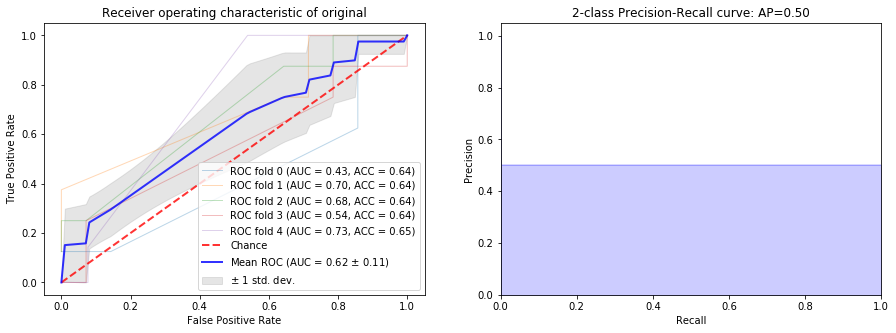

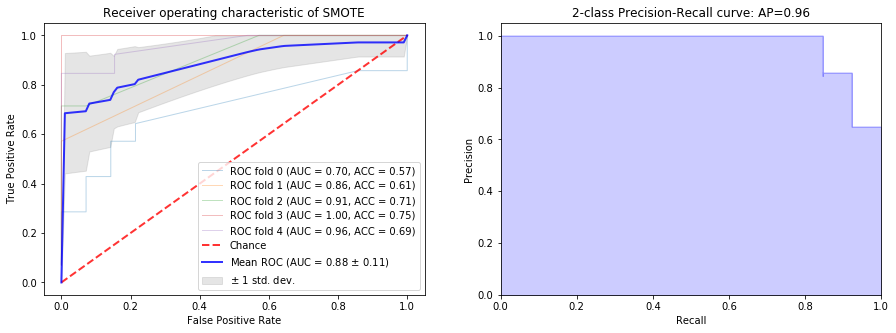

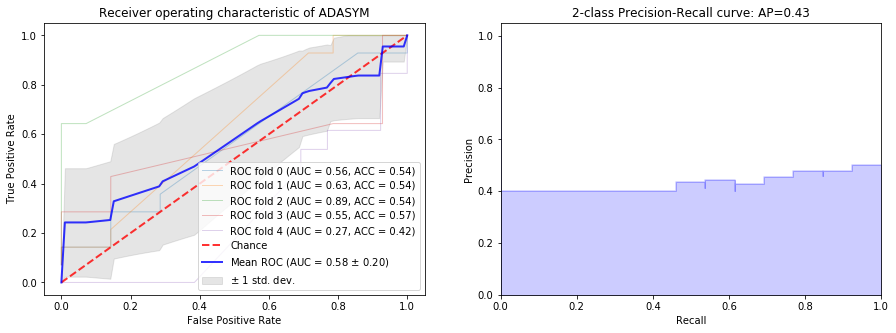

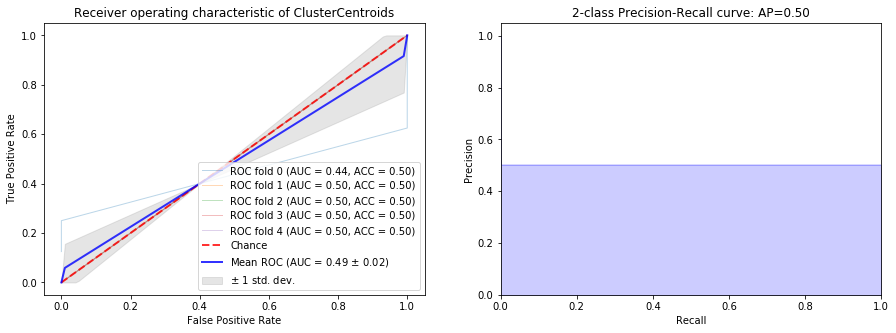

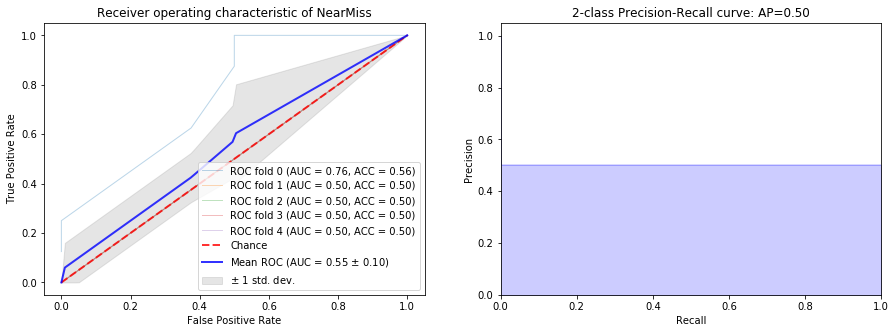

In [9]:
auc_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
auc_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0).fit_sample(X, y)
auc_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0).fit_sample(X, y)
auc_cc = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm = compute_roc(res_X, res_y, title='NearMiss')

In [10]:
u, p_value = mannwhitneyu(auc_ori, auc_sm)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_ada)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_cc)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_nm)
print ("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.01835692818135205
two-sample wilcoxon-test 0.41726581135546437
two-sample wilcoxon-test 0.06568970948371847
two-sample wilcoxon-test 0.2589521981862879


In [11]:
y_pred = clf_binary.fit(X, y).predict_proba(X)

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
y_pred_res = clf_binary.fit(res_X, res_y).predict_proba(X)

C:\Users\Liuya\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
temp_pd = os104
temp_pd['original'] = y_pred[:, 1].round()
temp_pd['smote'] = y_pred_res[:, 1].round()
temp_pd.head(5)

,bbs_days,bbs_num,in_watching_num,no_watching_num,online_hw,online_quiz,pgm,post_watching_num,pre_watching_num,quiz,re_watching_num,video_time_between_start_first_watching,video_watching_days,video_watching_num,video_watching_times,video_watching_total_time,class,original,smote
0,0.10,0.50,0.00,3.15,44.166667,100.000000,64.333333,1.15,0.0,39.000000,0.00,35.50,0.90,3.15,4.70,221.2,True,1.0,1.0
1,0.00,0.00,0.05,3.10,55.833333,97.750000,0.000000,0.80,0.0,36.000000,0.05,34.95,0.85,1.50,2.65,112.0,True,1.0,1.0
2,0.30,1.35,0.00,3.15,44.166667,98.166667,75.333333,0.65,0.0,45.333333,0.00,32.70,1.20,1.05,2.60,220.3,False,0.0,0.0
3,0.45,1.45,0.20,2.95,70.000000,96.500000,37.666667,2.90,0.0,68.666667,0.15,38.25,0.95,8.15,13.15,209.1,False,0.0,0.0
4,0.10,0.50,0.00,3.15,85.833333,100.000000,32.666667,0.00,0.0,61.000000,0.00,18.95,0.40,1.10,1.60,1.0,True,1.0,1.0


In [13]:
origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

<Figure size 1080x1080 with 0 Axes>

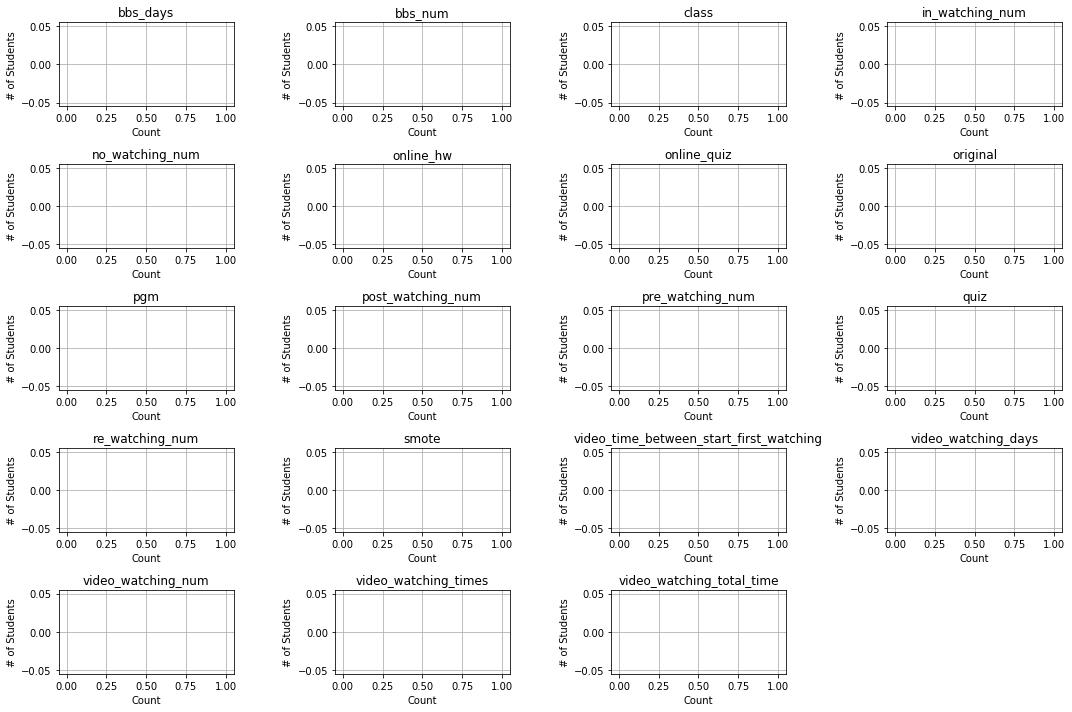

In [14]:
plt.figure(figsize=(15, 15))
ax = origin_pd.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_original' + '.png'
plt.savefig(image_name, dpi=300)

<Figure size 1080x1080 with 0 Axes>

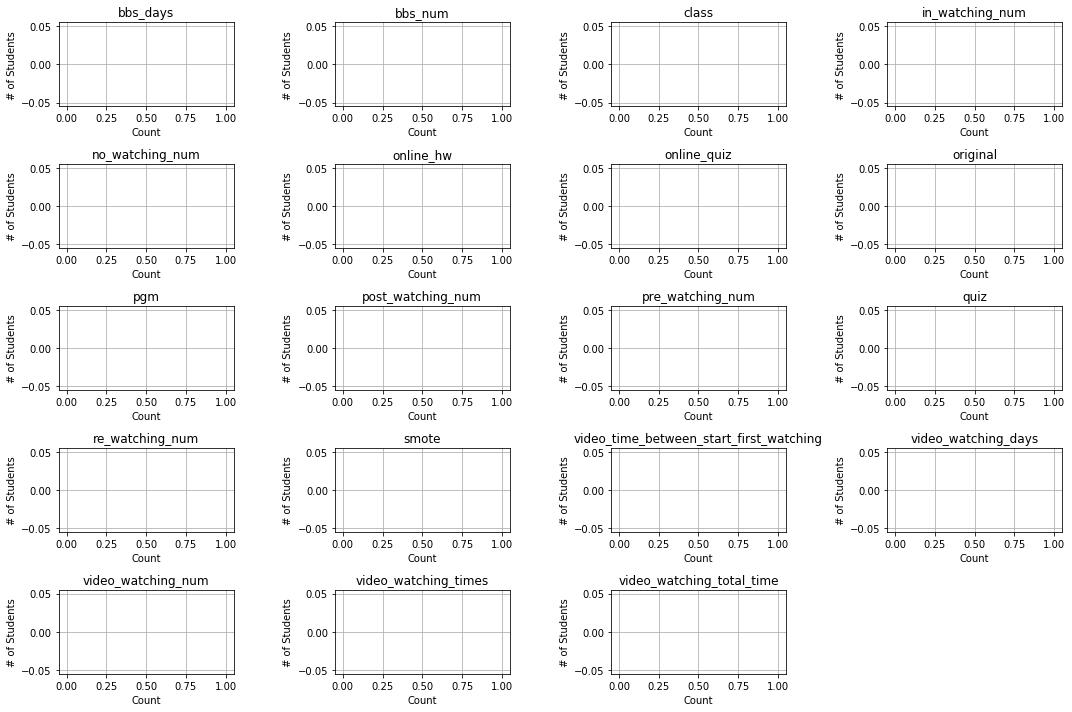

In [15]:
plt.figure(figsize=(15, 15))
ax = smote_pd.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_smote' + '.png'
plt.savefig(image_name, dpi=300)